This notebook calculates the distance to the nearest 10^5.5 and 10^ 6.5 Msun molecular cloud from the locations of each of the SNe located within 150pc maps.

In [2]:
#import packages and initialize settings
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.io import ascii
from astropy.table import Table
from progressbar import progressbar
from astropy.wcs import WCS
from reproject import reproject_interp

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
from deprojectGalaxy import deproject

In [3]:
# Unpack master table to get SNe information
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")

centerCoords = [(database["orient_ra"][i], database["orient_dec"][i]) for i in range(len(database))]    
SNe, SNra, SNdec  = database["SN_name"], database["SN_ra"], database["SN_dec"]
database[0:1]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str74
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/ESO097-013_alphaCO21_Sun+20.fits


In [4]:
SNra  = np.array(SNra)
SNdec = np.array(SNdec)
massCutA = 10**5.5
massCutB = 10**6.5


In [5]:
def angDistToPc(x,galDist):
    return(galDist*1000*np.tan(x*np.pi/180))

def findNearest(x1,x2,y1,y2):
    # Where x1 & y1 are 1d arrays of map coordinates
    # x2,y2 are the coords of the SNe
    n = len(x1)
    m = len(x2)
    if n != 0:
        x1Vec = np.tile(x1, (m,1)) #constant x along column
        y1Vec = np.tile(y1, (m,1)) #constant y along column
        x2Vec = np.tile(x2, (n,1)) #constant x along column
        y2Vec = np.tile(y2, (n,1)) #constant y along column
        x2Vec = np.transpose(x2Vec) #constant x along rows
        y2Vec = np.transpose(y2Vec) #constant y along rows

        dist = np.sqrt((x1Vec-x2Vec)**2 + (y1Vec-y2Vec)**2)    

        mindist = np.nanmin(dist, axis = 1)
    else: 
        mindist = float("nan")
    
    return(mindist)

def deprojectMap(galaxy, image, errimage, alphaCOimg, centerCoord, pa, incl, galDist, SNra, SNdec, SNe):
#convert pixel map to x' and y'
    
    if os.path.isfile(image):

        # read in fits files
        area = (150.0/2.0)**2*np.pi/np.log(2.0)
        hdu_int  = pyfits.open(image)
        intMap      = hdu_int[0].data

        hdu_err = pyfits.open(errimage)
        errMap      = hdu_err[0].data

        if(os.path.isfile(alphaCOimg)):
            hdu_aco  = pyfits.open(alphaCOimg)

            acoMap, footprint = reproject_interp(hdu_aco, hdu_int[0].header) 

            massMap = intMap * acoMap * area
        else: massMap = intMap * 6.7 * area

        #Convert x & y pixels to ra and dec
        wcs      = WCS(hdu_int[0].header, naxis=2)
        naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
        grid     = np.indices((naxis[1],naxis[0]))
        ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

        #deproject ra and dec to dx and dy
        radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec,return_offset=True)
        plt.imshow(intMap, origin='lower', interpolation='nearest', zorder=1)

        #flatten data structures 
        f_int  = intMap.flatten()
        f_err  = errMap.flatten()
        f_mass = massMap.flatten()
        f_ra   = ra.flatten()
        f_dec  = dec.flatten()    
        f_dx   = dx.flatten()
        f_dy   = dy.flatten()

        #remove nans
        keep  = np.where(np.isfinite(f_int))
        ra    = f_ra[keep]
        dec   = f_dec[keep]
        inten = f_int[keep]
        err   = f_err[keep]
        mass  = f_mass[keep]
        dx    = f_dx[keep]
        dy    = f_dy[keep]

        SNR = []
        for i in range(len(inten)):
            if err[i] == 0.0:
                SNR.append(0.0)
            elif inten[i] < 0.0:
                SNR.append(0.0)           
            else:
                SNR.append(inten[i]/err[i])       
        
        mass = mass.tolist()
        dx   = dx.tolist()
        dy   = dy.tolist()
        
        print("at Mass cutoff A for", galaxy)
        
        rmIdxs = [i for i, (a,b) in enumerate(zip(mass,SNR)) if (a < 10**5.5) or (b < 3.0)]
        for index in sorted(rmIdxs, reverse=True):
            del SNR[index]
            del mass[index]
            del dx[index]
            del dy[index]
        
        sndxArr, sndyArr = [],[]
        for j in range(len(SNe)):
            SNradius, SNprojang, SNdx, SNdy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=SNra[j], dec=SNdec[j], return_offset=True)           
            sndxArr.append(SNdx)
            sndyArr.append(SNdy)
                    
        nearestMCx55 = findNearest(dx, sndxArr, dy, sndyArr)
        nearestMC55 = angDistToPc(nearestMCx55,galDist)
        
        print("Nearest 55", nearestMC55, galaxy)        
        
        rmIdxs = [i for i, (a) in enumerate(mass) if (a < 10**6.5)]
        for index in sorted(rmIdxs, reverse=True):
            del mass[index]
            del dx[index]
            del dy[index]
            
        nearestMCx65 = findNearest(dx, sndxArr, dy, sndyArr)
        nearestMC65 = angDistToPc(nearestMCx65,galDist)                    
        
        print("Nearest 65", nearestMC65, galaxy)        
        
        print("done with", galaxy, " ", SNe)  
        return(nearestMC55, nearestMC65)
    else:
        print("No file for ", galaxy)
        return(float("nan"), float("nan"))



[None, array([0.01364605]), array([0.55655997]), array([0.01321117]), array([0.00491407]), array([0.01275901]), array([0.1489542]), array([0.19534568]), array([0.35979567]), array([0.01287783]), array([0.01284268]), array([1.22508167]), array([0.01592836]), array([0.00761477]), array([0.00716833]), array([0.00421925]), None, array([0.07117317]), array([0.00321098]), array([0.0076644]), array([0.58246467]), array([0.01154423]), array([0.00611075]), array([0.00733605]), array([0.01245564]), array([0.01044295]), array([0.0040826]), array([0.00808865]), array([0.01097162]), array([0.02066585]), array([0.08586097]), array([0.03508382]), array([0.02765949]), array([0.0155404]), array([0.03955008]), array([0.02026862]), array([0.2480944]), array([0.10081377]), array([0.0106565]), array([0.00660132]), array([0.06650442]), array([0.01621761]), array([0.03209613]), array([0.38714994]), array([0.00946752]), array([0.29470551]), array([0.10821323]), array([0.37426845]), None, None, array([5800.10100662]), array([0.01400941]), array([0.01271513]), array([0.00453499]), array([0.00497956]), array([0.00238751]), array([0.05432539]), array([0.00023186]), array([0.0098961]), array([0.01070017]), array([0.99123115])]

[0.03220571, 0.03057009, 0.31916941, 0.75480179, 0.02805144]

In [6]:
gal_group = database.group_by("galaxy")
# print(gal_group)

In [7]:
gal_group.groups.indices

array([ 0,  1,  2,  3,  5,  6,  7,  9, 12, 13, 14, 18, 20, 21, 22, 23, 25,
       26, 31, 35, 42, 48, 49, 50, 52, 53, 55, 56, 58, 63, 64, 65, 66])

In [8]:
#Set up sorted lists to make fewer runs with code above
gal, img, ers, aco, ccs, pas, inc, gds, SNr, SNd, SNa = [],[],[],[],[],[],[],[],[],[],[]
gala, imgs, errs, alco, cocs, pans, incl, gdis, SNrs, SNdc, SNea = [],[],[],[],[],[],[],[],[],[],[]
for i in range(len(database)):
    gal.append(database["galaxy"][i]) 
    img.append(database["ImageFile150"][i])
    ers.append(database["ErrFile150"][i])
    aco.append(database["AlphaCOFile"][i])
    ccs.append(centerCoords[i])
    pas.append(database["orient_posang"][i])
    inc.append(database["orient_incl"][i])
    gds.append(database["dist"][i])
    SNr.append(SNra[i])
    SNd.append(SNdec[i])
    SNa.append(SNe[i])
    
    if (i+1) in gal_group.groups.indices:
        gala.append(gal) 
        imgs.append(img)
        errs.append(ers)
        alco.append(aco)
        cocs.append(ccs)
        pans.append(pas)
        incl.append(inc)
        gdis.append(gds)
        SNrs.append(SNr)
        SNdc.append(SNd)
        SNea.append(SNa) 
        gal, img, ers, aco, ccs, pas, inc, gds, SNr, SNd, SNa = [],[],[],[],[],[],[],[],[],[],[]
    else:
        pass
        

In [9]:
#for i in range(len(gal_group.groups.indices)-1):
print(SNea)

[['SN1996cr'], ['SN1940E'], ['SN2019qyl'], ['SN2019krl', 'SN2013ej'], ['SN2018ivc'], ['SN1995V'], ['SN1999eu', 'SN1992bd'], ['SN2001du', 'SN1983V', 'SN2012fr'], ['SN1985P'], ['SN1935C'], ['SN1984J', 'SN1986L', 'SN2005df', 'SN2009ib'], ['SN2010el', 'ASASSN-14ha'], ['SN1999em'], ['SN2017gax'], ['SN1993Z'], ['SN2003jg', 'SN2008eh'], ['SN2012A'], ['SN2009hd', 'SN1997bs', 'SN1973R', 'SN1989B', 'SN2016cok'], ['SN1972Q', 'SN1967H', 'SN2014L', 'SN1986I'], ['SN2006ov', 'SN2020jfo', 'SN2014dt', 'SN1964F', 'SN1961I', 'SN1999gn', 'SN1926A'], ['SN2006X', 'SN1959E', 'SN2020oi', 'SN1979C', 'SN1901B', 'SN2019ehk'], ['SN2012cg'], ['SN2020nvb'], ['SN1988M', 'SN1960F'], ['SN1981B'], ['SN1988A', 'SN1989M'], ['SN2011ja'], ['SN1986G', 'SN2016adj'], ['SN1957D', 'SN1923A', 'SN1950B', 'SN1983N', 'SN1968L'], ['SN2007it'], ['SN2005at'], ['SN2008bk']]


at Mass cutoff A for circinus
Nearest 55 [0.03220571] circinus
Nearest 65 [0.03220571] circinus
done with circinus   ['SN1996cr']
at Mass cutoff A for ngc0253
Nearest 55 [0.03057009] ngc0253
Nearest 65 [0.03057009] ngc0253
done with ngc0253   ['SN1940E']
at Mass cutoff A for ngc0300
Nearest 55 [0.31916941] ngc0300
Nearest 65 nan ngc0300
done with ngc0300   ['SN2019qyl']
at Mass cutoff A for ngc0628
Nearest 55 [0.75480179 0.09787336] ngc0628
Nearest 65 [1.38461405 1.90558439] ngc0628
done with ngc0628   ['SN2019krl', 'SN2013ej']
No file for  ngc1068
at Mass cutoff A for ngc1087
Nearest 55 [0.01364605] ngc1087
Nearest 65 [0.64031667] ngc1087
done with ngc1087   ['SN1995V']
at Mass cutoff A for ngc1097
Nearest 55 [0.55655997 0.01321117] ngc1097
Nearest 65 [6.54995977 0.01321117] ngc1097
done with ngc1097   ['SN1999eu', 'SN1992bd']
at Mass cutoff A for ngc1365
Nearest 55 [0.17545338 0.01275901 0.3627857 ] ngc1365
Nearest 65 [2.33406823 0.45816414 1.0996273 ] ngc1365
done with ngc1365   ['S

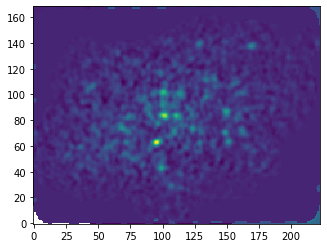

In [10]:

nearest55, nearest65 = [],[]
for i in range(len(gala)):
    near55, near65 = deprojectMap(gala[i][0], imgs[i][0], errs[i][0], alco[i][0], cocs[i][0], pans[i][0], incl[i][0], gdis[i][0], SNrs[i], SNdc[i], SNea[i])
    nearest55.append(near55)
    nearest65.append(near65)

In [11]:
nearest55Array = [0.03220571, 0.03057009, 0.31916941, 0.75480179, 0.09787336, 'nan', 0.55655997, 0.01321117, 
                  0.17545338, 
 0.01275901, 0.3627857, 0.19534568, 0.35979567, 0.01287783, 0.250405, 1.22508167, 0.01592836, 0.00761477, 
 0.00716833, 0.00421925, "nan", 0.18460691, 0.00321098, 0.0076644, 0.81649887, 0.01154423, 0.00611075, 
 0.00733605, 0.01245564, 0.01044295, 0.0040826 , 0.00808865, 0.01097162, 0.02066585, 0.10946816, 0.06258017, 
 0.05928866, 0.01926747, 0.2711221, 0.02026862, 0.34278674, 0.12665805, 0.0106565 , 0.00660132, 0.09696834, 
 0.01621761, 0.08157655, 0.41066955, 0.00946752, 0.29470551, 0.10821323, 0.37426845, "nan", 5800.10100662, 
 0.01400941, 0.01271513, 0.00453499, 0.00497956, 0.00238751, 0.05432539, 0.00023186, 0.0098961, 0.01070017, 
                  0.99123115]
print(len(nearest55Array))

64


In [21]:
n55A = []
for i in range(len(nearest55)):
    if(type(nearest55[i])!= float):
        for j in range(len(nearest55[i])):
            n55A.append(nearest55[i][j])
    else:
        n55A.append(nearest55[i])
print(n55A)

n65A = []
for i in range(len(nearest65)):
    if(type(nearest65[i])!= np.float64 and type(nearest65[i]) != float):
        for j in range(len(nearest65[i])):
            n65A.append(nearest65[i][j])
    else:
        n65A.append(nearest65[i])
print(n65A)

[0.03220571074533962, 0.03057009156537961, 0.31916941389924186, 0.7548017888319929, 0.09787335683310962, nan, 0.013646047502189571, 0.5565599733157864, 0.013211165591673027, 0.1754533798560515, 0.012759013584611812, 0.36278570368097374, 0.19534567604068137, 0.35979566719711, 0.012877828305613197, 0.25040500480337446, 1.2250816695880822, 0.01592835670677876, 0.007614765089822284, 0.007168330791430103, 0.004219252731837075, nan, 0.1846069112016708, 0.003210982238446186, 0.007664398908642832, 0.8164988728454339, 0.011544233889814256, 0.006110750871314156, 0.007336047333005576, 0.012455637161524646, 0.010442954646936868, 0.004082603353940458, 0.008088649613442416, 0.010971624901057561, 0.020665852834243447, 0.10946815538240745, 0.06258017443150858, 0.05928866404829043, 0.019267465489400375, 0.2711220951817008, 0.020268616500006675, 0.3427867435920636, 0.12665804626520982, 0.01065649565432733, 0.006601320975171955, 0.09696833984548939, 0.016217608974124317, 0.0815765457719991, 0.41066954858

In [24]:
with open("../Data/NearestMCtoSNe.txt", "w") as textFile:
    print("# Nearest55MassArrayDistances, Nearest65MassArrayDistances (in pc)", file=textFile)
    print(n55A, n65A, file=textFile)

In [22]:
print(database["dist"])

 dist
-----
  4.2
  3.7
 2.09
 9.84
 9.84
13.97
15.85
13.58
13.58
19.57
  ...
 3.47
 3.69
 3.69
 4.89
 4.89
 4.89
 4.89
 4.89
12.27
 9.39
 3.62
Length = 66 rows
